In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from iminuit import Minuit, cost
#mcfile = uproot.open("/dune/data/users/yinrui/MC0_211205/pduneana_MC.root:pduneana")
#datafile = uproot.open("/dune/data/users/yinrui/data_211203/pduneana_data.root:pduneana")
mcfile = uproot.open("/dune/app/users/yinrui/systematics/thinslice/build/newtree_0718_proton_MC.root")
datafile = uproot.open("/dune/app/users/yinrui/systematics/thinslice/build/newtree_0718_proton_data.root")

In [2]:
branches = ["beam_inst_P", "reco_beam_calo_startX", "reco_beam_calo_startY", "reco_beam_calo_startZ", "reco_beam_calo_endX", "reco_beam_calo_endY", "reco_beam_calo_endZ", "true_beam_startP", "reco_KE_from_trklen"]
momin = 0.7; momax = 1.3

fakedata = False

#mcevt = mcfile["beamana"].arrays(branches, "(event%2==1)")
mcevt = mcfile["beamana"].arrays(branches)
if fakedata:
    dataevt = mcfile["beamana"].arrays(branches, "(event%2==0)")
else:
    dataevt = datafile["beamana"].arrays(branches)

mcP = mcevt["beam_inst_P"]
mcP_true = mcevt["true_beam_startP"]
dataP = dataevt["beam_inst_P"]
reco_KE_data = dataevt["reco_KE_from_trklen"]
reco_KE_MC = mcevt["reco_KE_from_trklen"]

MC selected events: 27510 	Data selected events: 19414


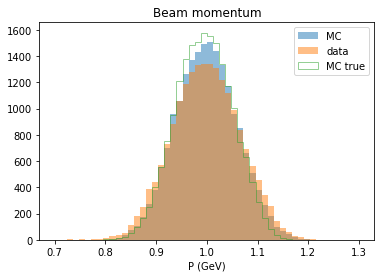

In [3]:
nmc = len(mcP); ndata = len(dataP)
print("MC selected events:", nmc, "\tData selected events:", ndata)
mcweight = np.ones_like(mcP)*ndata/nmc
#print("Cut:", precut + f" & (Beam Quality Cut)")

nnmc, xemc, _ = plt.hist(mcP, bins=50, alpha=0.5, label="MC", weights=mcweight, range=[momin,momax])
nndt, xedt, _ = plt.hist(dataP, bins=50, alpha=0.5, label="data", range=[momin,momax])
nnmc_t, xemc_t, _ = plt.hist(mcP_true, bins=50, alpha=0.5, label="MC true", weights=mcweight, range=[momin,momax], histtype="step")
plt.legend()
plt.title("Beam momentum")
plt.xlabel("P (GeV)")
plt.show()

In [4]:
def gauss_pdf(x, mu, sigma):
    return norm.pdf(x, mu, sigma)
def gauss_cdf(xe, mu, sigma):
    return norm.cdf(xe, mu, sigma)
def gauss_extpdf(x, mu, sigma, n):
    #return n, n*norm.pdf(x, mu, sigma)
    return n*norm.pdf(x, mu, sigma)

#c1 = cost.UnbinnedNLL(mcP, gauss_pdf)
#c2 = cost.UnbinnedNLL(dataP, gauss_pdf)
#c3 = cost.UnbinnedNLL(mcP_true, gauss_pdf)
#c1 = cost.BinnedNLL(nnmc, xemc, gauss_cdf)
#c2 = cost.BinnedNLL(nndt, xedt, gauss_cdf)
#c3 = cost.BinnedNLL(nnmc_t, xemc_t, gauss_cdf)
#c3 = cost.ExtendedUnbinnedNLL(mcP_true, gauss_extpdf)
c1 = cost.LeastSquares((xemc[1:]+xemc[:-1])/2, nnmc, np.maximum(np.sqrt(nnmc),1), gauss_extpdf)
c2 = cost.LeastSquares((xedt[1:]+xedt[:-1])/2, nndt, np.maximum(np.sqrt(nndt),1), gauss_extpdf)
c3 = cost.LeastSquares((xemc_t[1:]+xemc_t[:-1])/2, nnmc_t, np.maximum(np.sqrt(nnmc_t),1), gauss_extpdf)

'''m1 = Minuit(c1, mu=1, sigma=0.07)
#m1.fixed["cc"]=True
m1.migrad()
mu0inst = m1.values["mu"]
sigma0inst = m1.values["sigma"]
print(f"MC fitted (mu, sigma) = ({mu0inst}, {sigma0inst})")

m2 = Minuit(c2, mu=1, sigma=0.07)
m2.migrad()
muu = m2.values["mu"]
sigmaa = m2.values["sigma"]
print(f"Data fitted (mu, sigma) = ({muu}, {sigmaa})") # data

m3 = Minuit(c3, mu=1, sigma=0.07)
m3.migrad()
mu0 = m3.values["mu"]
sigma0 = m3.values["sigma"]
print(f"MC true fitted (mu, sigma) = ({mu0}, {sigma0})") # MC true'''

# Least Squares
m1 = Minuit(c1, mu=1, sigma=0.06, n=2000)
m1.migrad()
mu0inst = m1.values["mu"]; mu0inst_err = m1.errors["mu"]
sigma0inst = m1.values["sigma"]; sigma0inst_err = m1.errors["sigma"]
print(f"MC fitted (mu, sigma, n) = ({mu0inst:.4f}±{mu0inst_err:.4f}, {sigma0inst:.4f}±{sigma0inst_err:.4f}, {m1.values['n']:.1f}±{m1.errors['n']:.1f})")

m2 = Minuit(c2, mu=1, sigma=0.06, n=2000)
m2.migrad()
muu = m2.values["mu"]; muu_err = m2.errors["mu"]
sigmaa = m2.values["sigma"]; sigmaa_err = m2.errors["sigma"]
print(f"Data fitted (mu, sigma, n) = ({muu:.4f}±{muu_err:.4f}, {sigmaa:.4f}±{sigmaa_err:.4f}, {m2.values['n']:.1f}±{m2.errors['n']:.1f})")

m3 = Minuit(c3, mu=1, sigma=0.06, n=2000)
m3.migrad()
mu0 = m3.values["mu"]; mu0_err = m3.errors["mu"]
sigma0 = m3.values["sigma"]; sigma0_err = m3.errors["sigma"]
print(f"MC true fitted (mu, sigma, n) = ({mu0:.4f}±{mu0_err:.4f}, {sigma0:.4f}±{sigma0_err:.4f}, {m3.values['n']:.1f}±{m3.errors['n']:.1f})") # MC true

MC fitted (mu, sigma, n) = (0.9988±0.0004, 0.0599±0.0003, 232.2±1.7)
Data fitted (mu, sigma, n) = (0.9982±0.0005, 0.0655±0.0003, 231.7±1.7)
MC true fitted (mu, sigma, n) = (0.9938±0.0004, 0.0545±0.0002, 230.6±1.7)


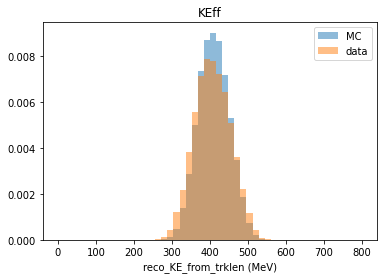

In [5]:
#MC_dXYZ = MCdistance[BQcut_MC]
#data_dXYZ = datadistance[BQcut_data]
MC_dXYZ = reco_KE_MC
data_dXYZ = reco_KE_data

plt.hist(MC_dXYZ,density=True,bins=50,alpha=0.5,label="MC", range=[0,800])
plt.hist(data_dXYZ,density=True,bins=50,alpha=0.5,label="data", range=[0,800])
plt.legend()
plt.title("KEff")
plt.xlabel("reco_KE_from_trklen (MeV)")
plt.show()

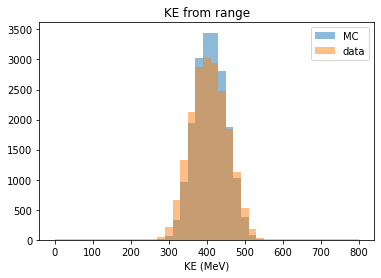

In [6]:
#dmin = 700; dmax = 1100
xbins = [0, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490, 510, 530, 550, 800] # xbins for dXYZ Chi2 fit
nbins = len(xbins)-1
plt.hist(MC_dXYZ, bins=xbins, alpha=0.5, label="MC", weights=mcweight)
datahist, bin_edges, _ = plt.hist(data_dXYZ, bins=xbins, alpha=0.5, label="data")
plt.legend()
#plt.title("dXYZ")
#plt.xlabel("Distance (cm)")
plt.title("KE from range")
plt.xlabel("KE (MeV)")
plt.show()

def getChi2(mu=muu, sigma=sigmaa, mu0=mu0, sigma0=sigma0, wlimit = 3):
    deno = np.exp(-(mcP_true - mu0)**2/2/sigma0**2)#/sigma0
    numo = np.exp(-(mcP_true - mu)**2/2/sigma**2)#/sigma
    #numo = np.maximum(numo, wlimit)
    #print(sum(numo/deno))
    #print(len(numo/deno))
    #print(normfact)
    weight = numo/deno
    #normfact = len(numo)/sum(weight)
    #weight = weight*normfact
    weight = np.maximum(weight, 1/wlimit)
    weight = np.minimum(weight, wlimit)
    normfact = len(numo)/sum(weight) * mcweight
    weight = weight * normfact
    MChist, _ = np.histogram(MC_dXYZ, bins=xbins, weights=weight)
    chi2 = (datahist - MChist)**2/np.maximum(datahist + MChist, 1)
    return np.sum(chi2[1:-1])/(nbins-3), weight


In [7]:
mu_list = np.linspace(0.975, 1.005, 100)
sigma_list = np.linspace(0.0525, 0.0725, 100)
#mu_list = np.linspace(1.0075, 1.0225, 20)
#sigma_list = np.linspace(0.06, 0.07, 20)
mm, ss = np.meshgrid(mu_list, sigma_list)
Chi2 = np.zeros_like(mm)
for i in range(len(mm)):
    for j in range(len(mm[0])):
        Chi2[i,j], _ = getChi2(mm[i,j], ss[i,j])

Obtained mu = 0.98955 (res 0.0003)
Obtained sigma = 0.06402 (res 0.0002)


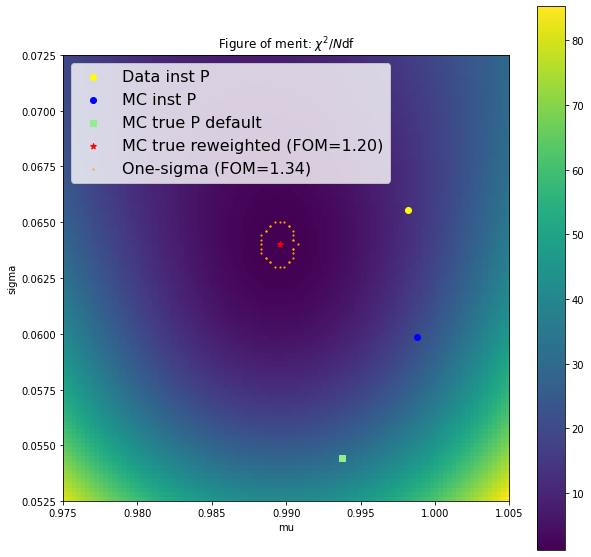

In [12]:
plt.figure(figsize=[10,10])
plt.imshow(Chi2,extent = [min(mu_list),max(mu_list),min(sigma_list),max(sigma_list)],origin="lower",aspect=(max(mu_list)-min(mu_list))/(max(sigma_list)-min(sigma_list)))
plt.colorbar()
plt.title(r"Figure of merit: $\chi^2/N{\rm df}$")
plt.xlabel("mu")
plt.ylabel("sigma")
plt.scatter([muu], [sigmaa], color="yellow", marker="o", label="Data inst P")
plt.scatter([mu0inst], [sigma0inst], color="blue", marker="o", label="MC inst P")
plt.scatter([mu0], [sigma0], color="lightgreen", marker="s", label="MC true P default")
minChi2 = np.min(Chi2)
minidx = np.where(Chi2 == minChi2)
onesigmaChi2 = minChi2 + 2.30/(nbins-1) # Table 40.2 https://pdg.lbl.gov/2020/reviews/rpp2020-rev-statistics.pdf
onesigmaidx = []
for i in range(len(mm)):
    for j in range(len(mm[0])-1):
        if Chi2[i,j]>onesigmaChi2 and Chi2[i,j+1]<onesigmaChi2:
            onesigmaidx.append([i,j])
        if Chi2[i,j]<onesigmaChi2 and Chi2[i,j+1]>onesigmaChi2:
            onesigmaidx.append([i,j+1])
for i in range(len(mm)-1):
    for j in range(len(mm[0])):
        if Chi2[i,j]>onesigmaChi2 and Chi2[i+1,j]<onesigmaChi2:
            onesigmaidx.append([i,j])
        if Chi2[i,j]<onesigmaChi2 and Chi2[i+1,j]>onesigmaChi2:
            onesigmaidx.append([i+1,j])
mur = mm[minidx][0]
sigmar = ss[minidx][0]
print(f"Obtained mu = {mur:.5f} (res {np.average(mu_list[1:]-mu_list[:-1]):.2g})")
print(f"Obtained sigma = {sigmar:.5f} (res {np.average(sigma_list[1:]-sigma_list[:-1]):.2g})")
plt.scatter(mur, sigmar, color="r", marker="*", label=f"MC true reweighted (FOM={minChi2:.2f})")
plt.scatter(mm[tuple(np.transpose(onesigmaidx))], ss[tuple(np.transpose(onesigmaidx))], color="orange", marker=".", s=5, label=f"One-sigma (FOM={onesigmaChi2:.2f})")
plt.legend(fontsize=16, loc="upper left")
plt.show()

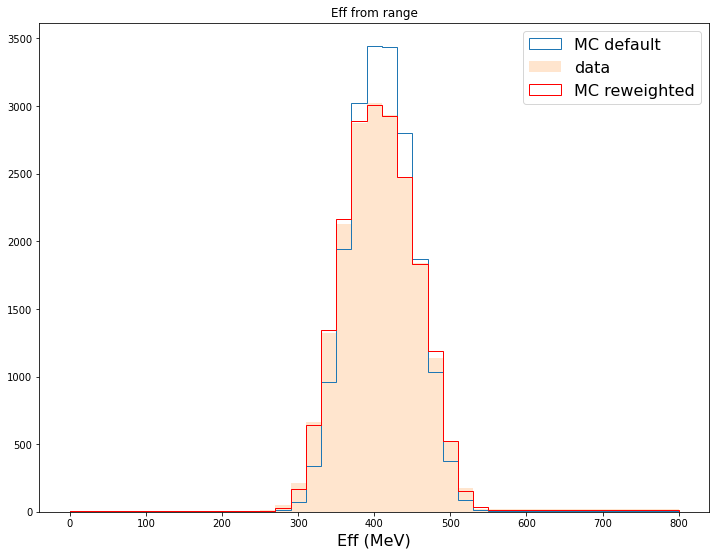

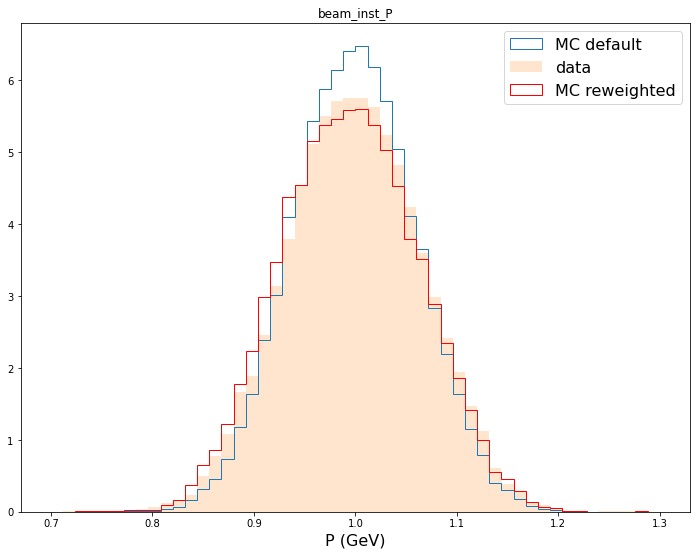

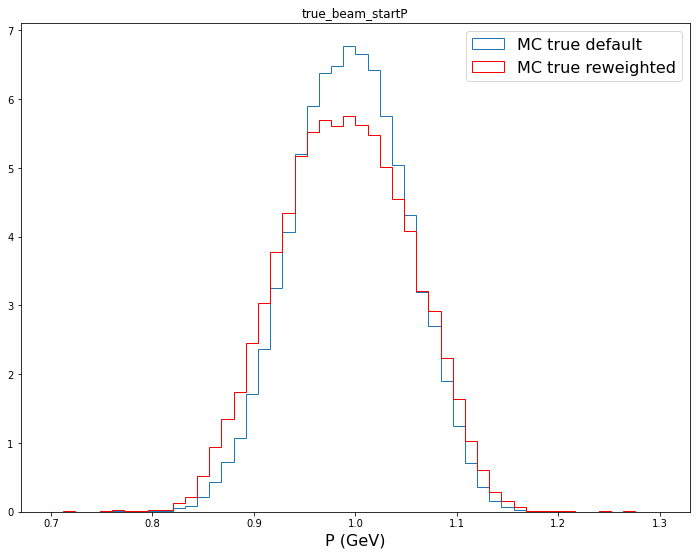

In [9]:
chi2, neweight = getChi2(mur, sigmar)
plt.figure(figsize=[12,9])
am,bm,_ = plt.hist(MC_dXYZ, density=False, bins=xbins, histtype="step", label="MC default", weights=mcweight)
aa,bb,_ = plt.hist(data_dXYZ, density=False, bins=xbins, alpha=0.2, label="data")
aw,bw,_ = plt.hist(MC_dXYZ, density=False, bins=xbins, histtype="step", label="MC reweighted", weights=neweight,color="r")
plt.legend(fontsize=16)
plt.title("Eff from range")
plt.xlabel("Eff (MeV)", fontsize=16)
plt.show()

nnbins = 50
plt.figure(figsize=[12,9])
amp,bmp,_ = plt.hist(mcP, bins=nnbins, histtype="step", label="MC default", weights=mcweight, range=[momin,momax], density=True)
aap,bbp,_ = plt.hist(dataP, bins=nnbins, alpha=0.2, label="data", range=[momin,momax], density=True)
awp,bwp,_ = plt.hist(mcP, bins=nnbins, histtype="step", label="MC reweighted", weights=neweight, range=[momin,momax],color="r", density=True)
plt.legend(fontsize=16)
plt.title("beam_inst_P")
plt.xlabel("P (GeV)", fontsize=16)
plt.show()

plt.figure(figsize=[12,9])
plt.hist(mcP_true, bins=nnbins, histtype="step", label="MC true default", weights=mcweight, range=[momin,momax], density=True)
plt.hist(mcP_true, bins=nnbins, histtype="step", label="MC true reweighted", weights=neweight, range=[momin,momax],color="r", density=True)
plt.legend(fontsize=16)
plt.title("true_beam_startP")
plt.xlabel("P (GeV)", fontsize=16)
plt.show()

(array([1.0341e+04, 3.7230e+03, 2.5490e+03, 1.9130e+03, 1.3670e+03,
        1.1380e+03, 9.2900e+02, 7.7600e+02, 5.9800e+02, 5.7200e+02,
        4.5400e+02, 3.5100e+02, 3.7100e+02, 2.6000e+02, 2.3300e+02,
        2.1300e+02, 1.8100e+02, 1.5200e+02, 1.4700e+02, 1.2900e+02,
        1.0600e+02, 7.7000e+01, 7.9000e+01, 9.6000e+01, 6.4000e+01,
        3.7000e+01, 6.7000e+01, 5.2000e+01, 5.1000e+01, 4.2000e+01,
        3.2000e+01, 3.1000e+01, 3.3000e+01, 1.6000e+01, 2.2000e+01,
        1.5000e+01, 2.3000e+01, 1.9000e+01, 2.3000e+01, 1.8000e+01,
        1.1000e+01, 1.0000e+01, 1.6000e+01, 1.1000e+01, 1.3000e+01,
        1.4000e+01, 3.0000e+00, 1.1000e+01, 6.0000e+00, 1.1500e+02]),
 array([0.59604544, 0.62016903, 0.64429263, 0.66841622, 0.69253982,
        0.71666341, 0.74078701, 0.76491061, 0.7890342 , 0.8131578 ,
        0.83728139, 0.86140499, 0.88552858, 0.90965218, 0.93377577,
        0.95789937, 0.98202296, 1.00614656, 1.03027016, 1.05439375,
        1.07851735, 1.10264094, 1.12676454, 1.

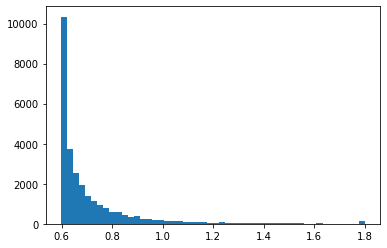

In [10]:
plt.hist(neweight,bins=50)